In [1]:
import pathlib
import pandas as pd

Inbreast_folder = pathlib.Path('/media/HD/mamo/INbreast/AllDICOMs')

Inbreast_images = list(Inbreast_folder.glob('**/*.dcm'))
print("Number of images in INbreast dataset: ", len(Inbreast_images))


Number of images in INbreast dataset:  410


In [ ]:
anots_folder = pathlib.Path('/home/alalbiol/Programacion/Mammography/exclude_git/DezsoRibli/src/prepare_data/inbreast/my_rois')

anots_files = list(anots_folder.glob('*.tsv'))
# delete SYNAPSE_METADATA_MANIFEST.tsv
anots_files = [f for f in anots_files if f.name != 'SYNAPSE_METADATA_MANIFEST.tsv']
print("Number of annotation files in INbreast dataset: ", len(anots_files))




Number of annotation files in INbreast dataset:  159


In [7]:
def read_anotations(anot_file):
    """Read annotations from a TSV file."""
    df = pd.read_csv(anot_file, sep='\t')
    annotations = []
    id = anot_file.stem
    for i in range(len(df)):
        #is it benign or malignant? otherwise skip
        if df.desc[i][0] == 'b':
            patho='BENIGN'
        elif df.desc[i][0] == 'm':
            patho='MALIGNANT'
        else:
            continue
        annotations.append({
            'id': id,
            'minx': df.x0[i],
            'miny': df.y0[i],
            'maxx': df.x1[i],
            'maxy': df.y1[i],
            'pathology': patho,
            'cancer': 1 if patho == 'MALIGNANT' else 0
        })
            
        #make xy from bounding box
    return annotations
    
    
    
    return df

In [9]:
all_annotations = []
for anot_file in anots_files:
    annotations = read_anotations(anot_file)
    all_annotations.extend(annotations)
    
print("Total number of annotations: ", len(all_annotations))

Total number of annotations:  194


In [12]:
all_annotations_df = pd.DataFrame(all_annotations)
print(all_annotations_df.head())
print(all_annotations_df.cancer.value_counts())

         id  minx  miny  maxx  maxy  pathology  cancer
0  22670094  2618   981  3309  1587  MALIGNANT       1
1  20586934    46  1882   454  2277  MALIGNANT       1
2  22670511   432  1602   702  1795  MALIGNANT       1
3  22670511   292   955   786  1437  MALIGNANT       1
4  22670511   234  1808   750  2326  MALIGNANT       1
cancer
1    102
0     92
Name: count, dtype: int64


In [15]:
# detections

detections = pd.read_csv('detections_inbreast.csv')
detections['id'] = detections['id'].apply(lambda x: x.split('_')[0])  # Remove file parts
print(detections.head())

         id   box_x1   box_y1   box_x2   box_y2   score
0  20586908  2381.35  1547.47  2651.42  1835.88  0.7603
1  20586908  2307.61   904.98  2554.26  1196.95  0.6865
2  20586908  3094.90  1013.74  3296.04  1200.41  0.5852
3  20586908  2074.81  2410.66  2316.38  2617.86  0.3527
4  20586908  2496.82   455.18  2884.18   875.06  0.1501


In [18]:
detections_scores = detections.groupby('id')['score'].max().reset_index()
print("Number of images with detections: ", len(detections_scores))

Number of images with detections:  350


In [20]:
cancer_label = all_annotations_df.groupby('id')['cancer'].max().reset_index()
print(cancer_label.head())

         id  cancer
0  20586908       0
1  20586934       1
2  20586960       0
3  20586986       1
4  20587054       1


In [24]:
# merge detections_scores with cancer_label, set cancer=0 for images with no label

merged_df = pd.merge(detections_scores, cancer_label, on='id', how='outer')
merged_df['cancer'] = merged_df['cancer'].fillna(0).astype(int)
merged_df['score'] = merged_df['score'].fillna(0.0)

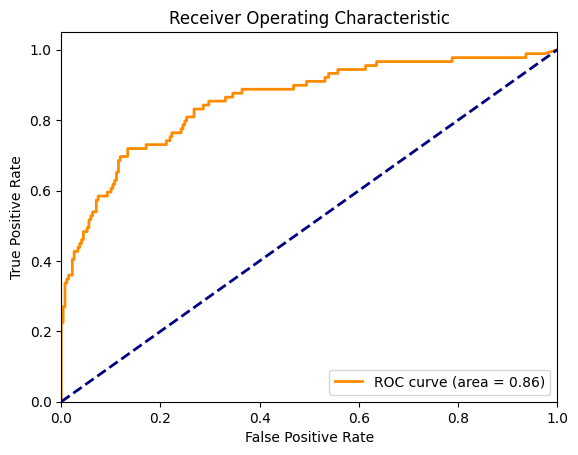

In [25]:
# calculate AUC and ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(merged_df['cancer'], merged_df['score'])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [29]:
all_annotations_df.to_csv('all_annotations_inbreast.csv', index=False)

In [30]:
detections.to_csv('detections_inbreast.csv', index=False)
